# Protein folding 
Using our implementation of the AMBER forcefield for protein folding. 
Currently, it lacks water. 


## Todo 
1. GNN sims
2. CG sims
3. add water 

In [23]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-1 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Annealer module

In [5]:
# Define an annealing scheduler
from torch.optim.lr_scheduler import ExponentialLR

class AnnealingLR(ExponentialLR):
    def __init__(self, optimizer, lr_min, lr_max, epochs, last_epoch=-1):
        self.epochs = epochs
        self.epoch_counter = 0 # we use this to know when to stop decaying the LR
        self.get_decay_rate(lr_min, lr_max, epochs)
        super(AnnealingLR, self).__init__(optimizer, self.gamma, last_epoch)
    
    def get_decay_rate(self, lr_min, lr_max, epochs):
        self.gamma = (lr_min/lr_max)**(1/epochs)
    
    # we can redefine step to change the learning rate only before "epochs" epochs
    def step(self):
        if self.epoch_counter < self.epochs:
            self.epoch_counter += 1
            super(AnnealingLR, self).step()
        else:
            pass

# Loading protein

In [6]:
# pdb_id = '2WXC' # '2JOF' # '5AWL'
pdb_id = '2JOF'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [7]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [8]:
system.getNumParticles(), system.getNumForces()

(284, 5)

In [9]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

In [10]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# p_.addModel(pf.get_file_text(pdb_file), 'pdb')
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


In [12]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energy Minimization

In [14]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
pdb_energy

99245.3828125

## Starting from PDB positions

In [24]:
# define the initial position
initial_pos = x = prot.node_positions.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [25]:
h = energy_minimizer.train(10000)

Early stopping at step 3820


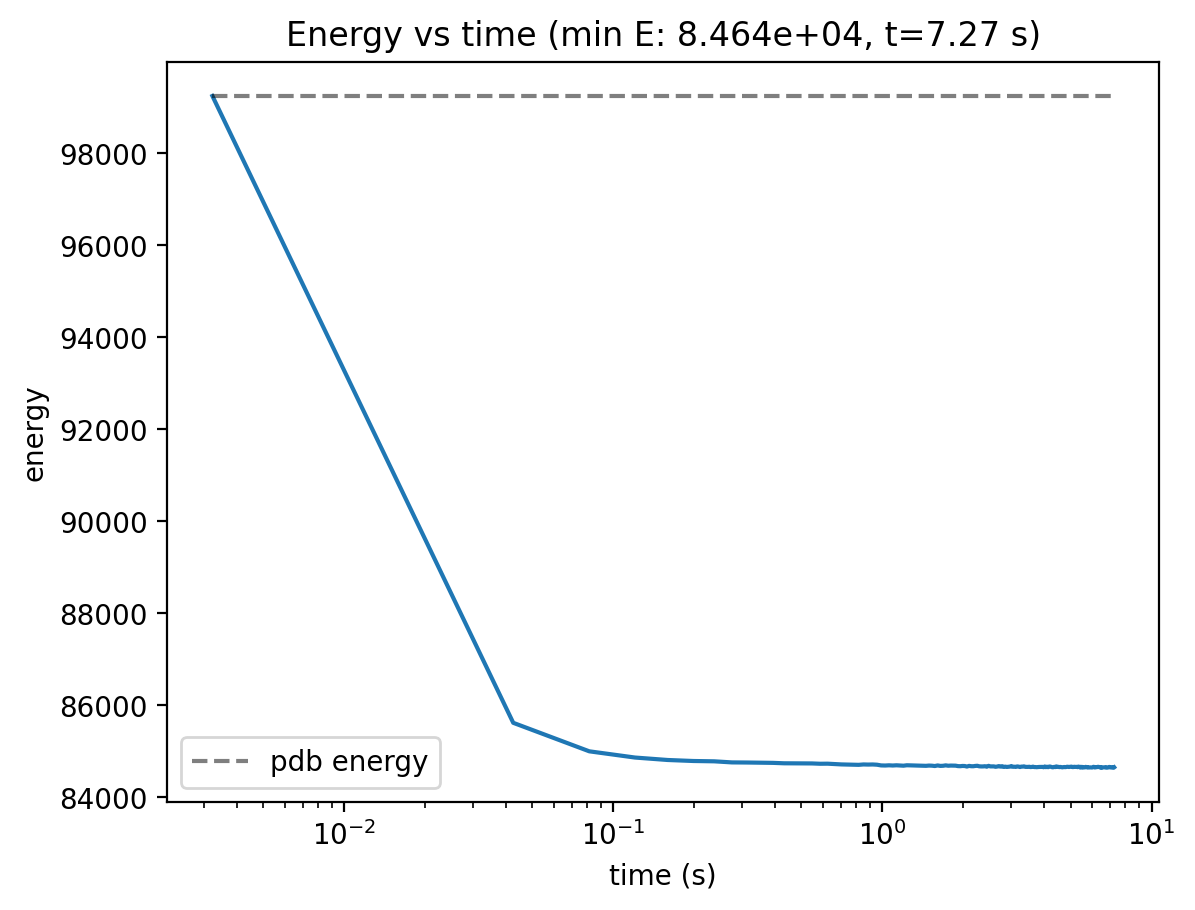

In [26]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [27]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4871, 0.4551, 0.3484], device='cuda:0', grad_fn=<StdBackward0>)

In [28]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./PDB_refine-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [29]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 1.0950926358874051, 'CA': 0.8053816838948542, 'backbone': 0.7841616120611717}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Starting from Random Init

In [31]:
# define the initial position
x = torch.randn_like(prot.node_positions)
# scale x to have std = s*std of original positions
x = x * 1.5 * prot.node_positions.std(dim=0)
x = x.to(DEVICE)
initial_pos = x

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [32]:
energy_minimizer.min_delta

0.1

In [33]:
N = 100
drop_rate = 40 #10
annealer = AnnealingLR(energy_minimizer.optimizer, 
                    lr_max=energy_minimizer.lr, 
                    lr_min=energy_minimizer.lr/drop_rate, 
                    epochs=N)


In [34]:
annealer.gamma

0.9637833073548235

In [35]:
relax_counter = 10
for epoch in range(2*N):
    h = energy_minimizer.train(500)
    # also print the current lr
    
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    annealer.step()
    print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 440time: 40.40 s, pat:1, FG lr: 7.89e-04-04
epoch: 44, energy: 84889.7, time: 41.25 s, pat:20, FG lr: 7.61e-04
relaxing 9
Early stopping at step 460
epoch: 45, energy: 84889, time: 42.13 s, pat:20, FG lr: 7.33e-04
relaxing 8
Early stopping at step 420
epoch: 46, energy: 84889.1, time: 42.93 s, pat:20, FG lr: 7.06e-04
relaxing 7
Early stopping at step 460, time: 44.77 s, pat:16, FG lr: 6.56e-04
epoch: 49, energy: 84888.4, time: 45.64 s, pat:20, FG lr: 6.32e-04
relaxing 6
Early stopping at step 460
epoch: 50, energy: 84888, time: 46.51 s, pat:20, FG lr: 6.10e-04
relaxing 5
Early stopping at step 480
epoch: 51, energy: 84887.6, time: 47.42 s, pat:20, FG lr: 5.87e-04
relaxing 4
Early stopping at step 460
epoch: 52, energy: 84887.4, time: 48.30 s, pat:20, FG lr: 5.66e-04
relaxing 3
Early stopping at step 440, time: 49.21 s, pat:7, FG lr: 5.46e-04
epoch: 54, energy: 84887.4, time: 50.05 s, pat:20, FG lr: 5.26e-04
relaxing 2
Early stopping at step 420
epoch: 55, energy:

In [36]:
h = energy_minimizer.train(20000)

Early stopping at step 420


Text(0.5, 1.0, 'Energy vs time (min E: 8.489e+04, t=53.38 s)')

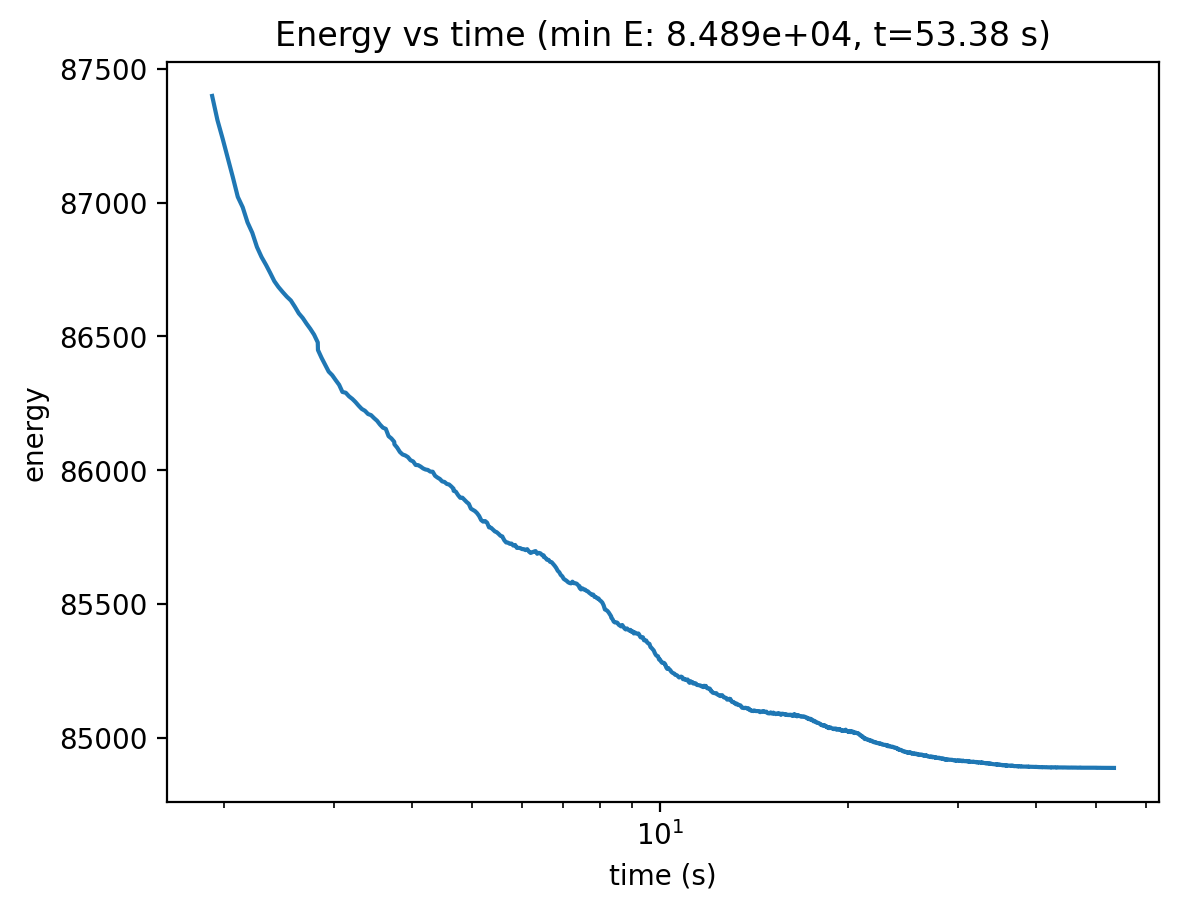

In [37]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 50

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [38]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4905, 0.4289, 0.3644], device='cuda:0', grad_fn=<StdBackward0>)

In [39]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GD-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [40]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [41]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [110]:
# prot.harmonic_bond_data['equilibrium_length']

# GNN

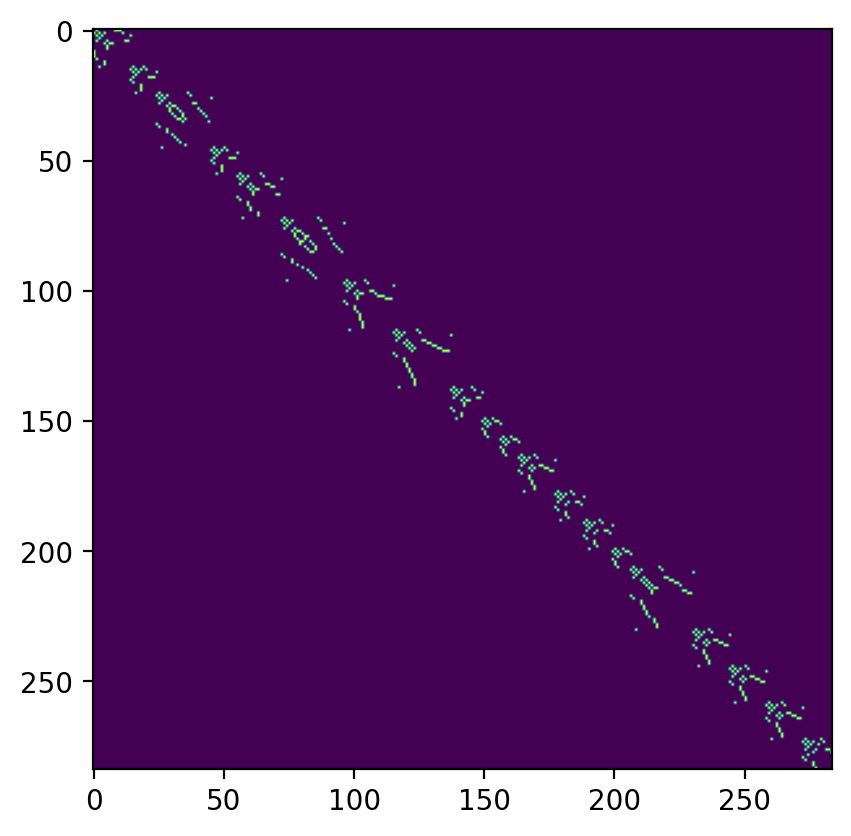

In [42]:
plt.imshow(V(prot.adjacency_matrix))

In [43]:
# to initialize random positions, we can 
# estimate the average volume occupied by each atom
# when the atoms are in a regular grid with
# the same distance between them. 
# we set this distance to 1.5A (average bond length)

# the volume occupied by each atom is a sphere with radius 1.5A
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius


0.9859707677163644

In [235]:
# MIN_DELTA = 1e-2
# PATIENCE = 20
# DEVICE = 'cuda'

In [128]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 300 #300
A = prot.adjacency_matrix.to(DEVICE)
# degree matrix
degs = torch.sum(A, dim=1)
D_inv = torch.diag(1/degs)
# degree normalized adjacency matrix
A_S = torch.eye(len(A)).to(DEVICE) + D_inv**(1/2) @ A @ D_inv**(1/2)

n = len(A)
d = 3
init_scaling = 3 #6 #1.5
gnn_reparam = GNNReparam([h, h//2, h//2, d], A=A_S,
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

gnn_minimizer = GNNMinimizer(energy, initial_pos, gnn_reparam, optimizer_type='Adam',
    lr=LR*5e-2, lr_gnn=LR*5e-3,
    # lr=4e-4, lr_gnn=1e-4,
    # lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e-1)


std after rescaling 2.95
Using Adam optimizer
Log name: GNN_protein_2JOF_
Logging to: ../results/logs/GNN_protein_2JOF__n284_d3
Using Adam optimizer


In [129]:
A_S 

tensor([[1.0000, 0.2500, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2500, 1.0000, 0.2887,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2887, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0')

In [130]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(2.9512, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(2.9512, device='cuda:0', grad_fn=<StdBackward0>))

In [131]:
N = 100
drop_rate = 40 #10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [132]:
# gnn_minimizer.min_delta *= 10

In [133]:
# annealer_fg.epochs = 200

In [140]:
relax_counter = 10
for epoch in range(2*N):
    h = gnn_minimizer.train(500)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        
        print('\n')
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 400, time: 150.45 s, pat:16, GNN lr: 5.19e-07
Starting fine-graining
Early stopping at step 400
epoch: 29, energy: 84629.7, time: 152.24 s, pat:20, FG lr: 1.93e-04


relaxing 9


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Early stopping at step 400
epoch: 30, energy: 84629.7, time: 153.04 s, pat:20, FG lr: 1.86e-04


relaxing 8
Early stopping at step 400
epoch: 31, energy: 84629.7, time: 153.84 s, pat:20, FG lr: 1.79e-04


relaxing 7
Early stopping at step 400
epoch: 32, energy: 84629.7, time: 154.63 s, pat:20, FG lr: 1.73e-04


relaxing 6
Early stopping at step 400
epoch: 33, energy: 84629.7, time: 155.43 s, pat:20, FG lr: 1.66e-04


relaxing 5
Early stopping at step 400
epoch: 34, energy: 84629.7, time: 156.23 s, pat:20, FG lr: 1.60e-04


relaxing 4
Early stopping at step 400
epoch: 35, energy: 84629.7, time: 157.02 s, pat:20, FG lr: 1.54e-04


relaxing 3
Early stopping at step 400
epoch: 36, energy: 84629.7, time: 157.82 s, pat:20, FG lr: 1.49e-04


relaxing 2
Early stopping at step 400
epoch: 37, energy: 84629.7, time: 158.61 s, pat:20, FG lr: 1.43e-04


relaxing 1
Early stopping at step 400
epoch: 38, energy: 84629.7, time: 159.39 s, pat:20, FG lr: 1.38e-04


relaxing 0
Early stopping at step 400
e

In [141]:
# gnn_minimizer.start_fine_graining()

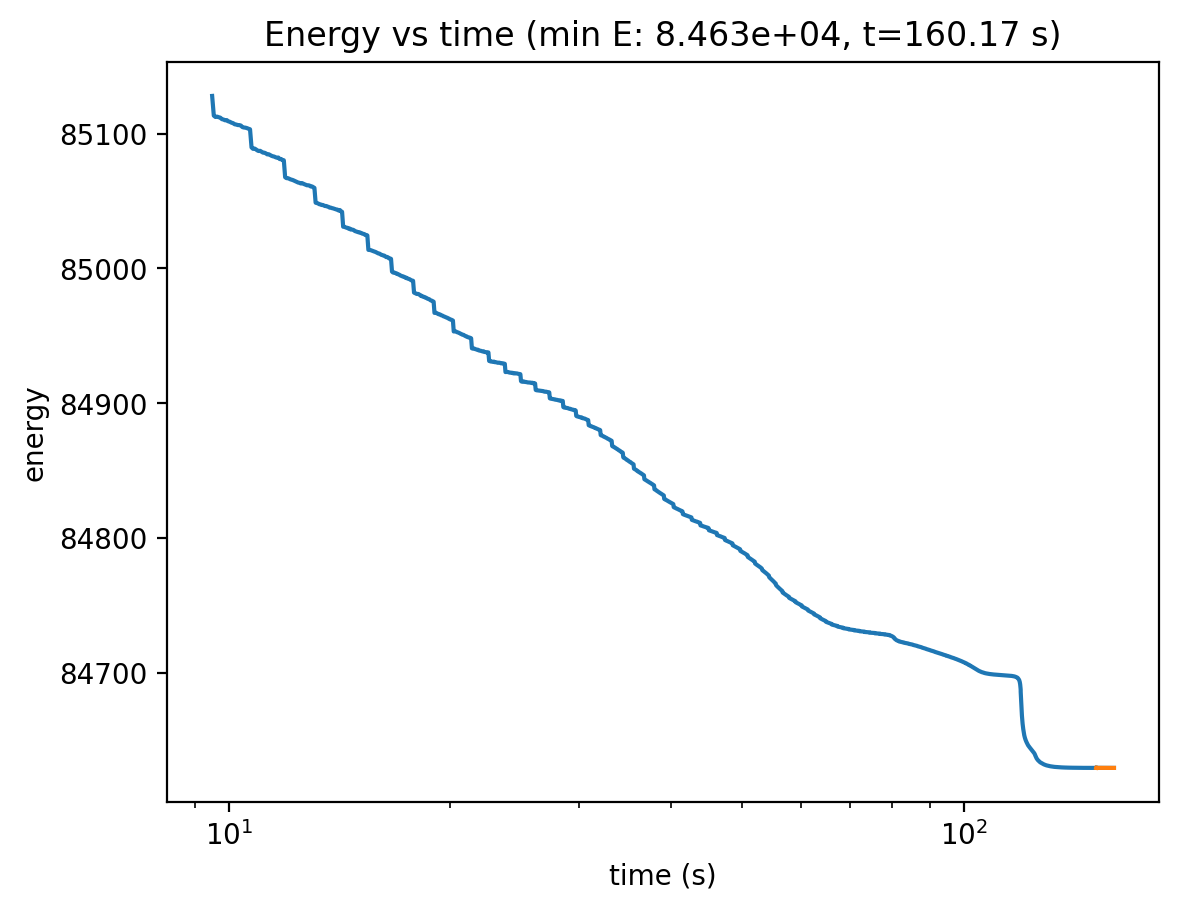

In [142]:
gnn_minimizer.plot_history(start=200)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')
plt.yscale('linear')


In [147]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.4020, 0.4460, 0.3813], device='cuda:0', grad_fn=<StdBackward0>)

In [148]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GNN-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [149]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [150]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.283522561211402, 'CA': 5.998512589009437, 'backbone': 5.865898452360015}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [100]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 7.440000581374548, 'CA': 6.19042277841242, 'backbone': 5.978464021446474}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [267]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.